### Measuring and characterizing fairness as a notion of inclusiveness.

Certain Machine Learning models are made to perform classification tasks of samples over labels which are subjective, what means that several users of the models might judge the label of the sample differently depending on their personal experience.

The predictions of the models might contain biases towards certain types of judgements which are more common than others and consequently easier to learn, and ignore other judgements. These biases might already be contained in the training dataset or generated by the classification model. 

However for the predictions to be fair towards each user of the model, they should be inclusive of all the different judgements, and possibly should be tuned to each of the users.

In this tutorial we teach:
- how to use metrics to measure how fair according to this notion of inclusiveness the models are,
- and how to use various characterizations of the predictions to understand where the unfairness might come from.

# Import statements

In [1]:
# Load all necessary packages
import sys
sys.path.append("../")  

#from aif360.datasets import GermanDataset
from aif360.datasets import ToxicityDataset
from aif360.metrics import InclusivenessLabelDatasetMetric

from IPython.display import Markdown, display


from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import sklearn.metrics as sk_met
from sklearn.base import TransformerMixin, BaseEstimator

import numpy as np
import pickle

## Load the toxicity dataset

In [2]:
### The toxicity dataset (toxicity_annotations.tsv, toxicity_annotated_comments.tsv, toxicity_worker_demographics.tsv) should be downloaded from https://figshare.com/articles/Wikipedia_Talk_Labels_Toxicity/4563973
### and placed in the folder "data/raw/toxicity".

tox_dataset = ToxicityDataset()

c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
### For now we do not use the whole dataset to be faster
n_lim = 500000
tox_dataset.dataset = tox_dataset.dataset[:n_lim]
dataset_orig_train, dataset_orig_test = tox_dataset.split([0.7], shuffle=True)

In [4]:
dataset_orig_train.dataset

,index,rev_id,worker_id,label,label_score,gender,english_first_language,age_group,education,pop_label,general_split,sample_agreement,MV,annotator_ADR,popularity_percentage,comment
248386,301471,91448177.0,2754,0,0.0,female,0.0,30-45,masters,female 30-45 masters,train,0.777778,0,0.051765,0.777778,think means wonder means something black peopl...
147572,179267,57799601.0,978,1,-1.0,male,0.0,18-30,bachelors,male 18-30 bachelors,train,0.800000,0,0.062361,0.200000,please add nonsense wikipedia considered vanda...
292846,355496,110264335.0,1457,1,-1.0,male,0.0,18-30,bachelors,male 18-30 bachelors,train,0.800000,0,0.203233,0.200000,never herad dynamic ip address well problem op...
149733,181855,58523936.0,983,0,0.0,male,0.0,18-30,professional,male 18-30 professional,train,1.000000,0,0.050114,1.000000,december 26 2004 kennet andersson killed tsuna...
11842,14363,9252365.0,3784,0,0.0,male,0.0,30-45,hs,male 30-45 hs,train,1.000000,0,0.124706,1.000000,cut even could probably use copyediting ævar a...
202426,245732,74297221.0,1642,0,1.0,male,0.0,30-45,masters,male 30-45 masters,train,1.000000,0,0.207373,1.000000,höganäs ab please move pages copying pasting c...
109515,133108,45978748.0,3446,0,0.0,male,1.0,18-30,some,male 18-30 some,train,1.000000,0,0.042353,1.000000,see
100756,122494,43118815.0,2471,0,2.0,male,0.0,18-30,professional,male 18-30 professional,train,0.800000,0,0.086854,0.800000,impumozhi knowledge lack rajputs incident 1 im...
300534,364836,113325155.0,1592,0,1.0,male,0.0,18-30,bachelors,male 18-30 bachelors,train,1.000000,0,0.052752,1.000000,creation page nija style tag placed nija style...
28165,34139,18139980.0,644,0,0.0,male,0.0,18-30,hs,male 18-30 hs,train,1.000000,0,0.038636,1.000000,former member inc understand desire critics re...


## Train a model with the loaded data

In [5]:
### Usually the annotations are aggregated into the majority vote (MV).
def prepare_aggregated_data(comment_):
    comments = comment_.dataset.drop_duplicates('rev_id')
    comments = comments.drop('index', 1)
    comments = comments.drop('label', 1)
    comments = comments.drop('label_score', 1)
    comments = comments.drop('worker_id', 1)
    comments = comments.drop('gender', 1)
    comments = comments.drop('age_group', 1)
    comments = comments.drop('education', 1)
    comments = comments.drop('pop_label', 1)
    comments = comments.drop('english_first_language', 1)
    return comments

In [6]:
dataset_train_comments = prepare_aggregated_data(dataset_orig_train)
dataset_test_comments = prepare_aggregated_data(dataset_orig_test)

In [7]:
### The ML model is then trained on the MV labels. 

embedding_model = 0
dense_outputs = 100 
batches = 128
sequence_length = 100 

In [8]:
dataset_train_comments

,rev_id,general_split,sample_agreement,MV,annotator_ADR,popularity_percentage,comment
248386,91448177.0,train,0.777778,0,0.051765,0.777778,think means wonder means something black peopl...
147572,57799601.0,train,0.800000,0,0.062361,0.200000,please add nonsense wikipedia considered vanda...
292846,110264335.0,train,0.800000,0,0.203233,0.200000,never herad dynamic ip address well problem op...
149733,58523936.0,train,1.000000,0,0.050114,1.000000,december 26 2004 kennet andersson killed tsuna...
11842,9252365.0,train,1.000000,0,0.124706,1.000000,cut even could probably use copyediting ævar a...
202426,74297221.0,train,1.000000,0,0.207373,1.000000,höganäs ab please move pages copying pasting c...
109515,45978748.0,train,1.000000,0,0.042353,1.000000,see
100756,43118815.0,train,0.800000,0,0.086854,0.800000,impumozhi knowledge lack rajputs incident 1 im...
300534,113325155.0,train,1.000000,0,0.052752,1.000000,creation page nija style tag placed nija style...
28165,18139980.0,train,1.000000,0,0.038636,1.000000,former member inc understand desire critics re...


In [9]:
class DataFrameColumnExtracter(BaseEstimator, TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column].as_matrix()#.reshape((-1,1))#.values.astype('U')
    
class DataFrameColumnExtracter_doc(BaseEstimator, TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column].values.astype('U')

In [10]:
### Perform grid search over the parameters of the model

# Parameters of the grid search
tuning_keys = ['clf__C', 'clf__tol']
tuned_parameters = {'clf__C': [1e-4, 1e-2, 1, 10], 'clf__tol': [1, 1e-2, 1e-4]} 

# Load the model # Logistic Regression model
clf_LR = Pipeline([# Sentences
                  ('sentences_features', Pipeline([
                      ('sentence_extractor', DataFrameColumnExtracter_doc('comment')),#.values.astype('U'),
                    ('vect', CountVectorizer(max_features = 1500, ngram_range = (1,5), analyzer = 'char')),
                     ('tf', TfidfTransformer(norm = 'l2'))
                  ])),
            # Classifier
            ('clf', LogisticRegression())#C=LR_C, tol=LR_C_tol))
        ])

# Perform grid search


clf = GridSearchCV(clf_LR, tuned_parameters, cv=5, verbose=0)


In [11]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [12]:
nb_data = 5000
#best_model = clf.fit(dataset_train_comments[0:nb_data], dataset_train_comments['MV'][0:nb_data])
#best_parameters = best_model.best_params_  
#print(best_parameters)  
#best_result = best_model.best_score_  
#print(best_result)  
#save_obj(best_parameters, 'best_param_LR_aggregated')

In [13]:
best_parameters = load_obj('best_param_LR_aggregated')
clf_LR.set_params(**best_parameters)
#clf_LR.fit(dataset_train_comments, dataset_train_comments['MV'])
clf_LR.fit(dataset_train_comments[0:nb_data], dataset_train_comments['MV'][0:nb_data])

c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('sentences_features', Pipeline(memory=None,
     steps=[('sentence_extractor', DataFrameColumnExtracter_doc(column='comment')), ('vect', CountVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lower...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [14]:
### Evaluate general performance
train_pred = clf_LR.predict(dataset_train_comments[0:nb_data])
test_pred = clf_LR.predict(dataset_test_comments[0:nb_data])
print("Training accuracy: ", sk_met.accuracy_score(dataset_train_comments['MV'][0:nb_data], train_pred))
print("Test accuracy: ", sk_met.accuracy_score(dataset_test_comments['MV'][0:nb_data], test_pred))

C_train = sk_met.confusion_matrix(dataset_train_comments['MV'][0:nb_data], train_pred)
C_train = C_train / C_train.astype(np.float).sum(axis=0)
C_test = sk_met.confusion_matrix(dataset_test_comments['MV'][0:nb_data], test_pred)
C_test = C_test / C_test.astype(np.float).sum(axis=0)
print("Training confusion matrix:", C_train)
print("Test confusion matrix:", C_test)

Training accuracy:  0.9384
Test accuracy:  0.9258
Training confusion matrix: [[0.9376585  0.04850746]
 [0.0623415  0.95149254]]
Test confusion matrix: [[0.93208184 0.18918919]
 [0.06791816 0.81081081]]


In [15]:
import collections
collections.Counter(dataset_train_comments['MV'][0:nb_data])

Counter({0: 4450, 1: 550})

## Compute the fairness performance (both on training and test datasets)

In [16]:
# The dataset might be too large for the classifier to process all the data. In this case, it is splitted to get all the values.
prediction_col = "pred_1"
dataset_orig_train.dataset[prediction_col] = -1
dataset_orig_test.dataset[prediction_col] = -1
nb_data = 5000

def compute_pred_dataset(dataset_orig_train, prediction_col, nb_data):
    for i in range(int(len(dataset_orig_train.dataset) / nb_data)):
        low_interval = i*nb_data
        high_interval = (i+1)*nb_data
        dataset_orig_train.dataset[prediction_col].iloc[low_interval:high_interval] = clf_LR.predict(dataset_orig_train.dataset.iloc[low_interval:high_interval])
    dataset_orig_train.dataset[prediction_col].iloc[high_interval:] = clf_LR.predict(dataset_orig_train.dataset.iloc[high_interval:])
    return dataset_orig_train
dataset_orig_train = compute_pred_dataset(dataset_orig_train, prediction_col, nb_data)
print(dataset_orig_train.dataset[prediction_col].value_counts())
print(len(dataset_orig_train.dataset))

dataset_orig_test = compute_pred_dataset(dataset_orig_test, prediction_col, nb_data)
print(dataset_orig_test.dataset[prediction_col].value_counts())
print(len(dataset_orig_test.dataset))

#train_pred = clf_LR.predict(dataset_train_comments[0:nb_data])
#test_pred = clf_LR.predict(dataset_test_comments[0:nb_data])
#dataset_train_comments["pred_1"] = train_pred
#dataset_test_comments["pred_1"] = test_pred

c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


0    272652
1     15568
Name: pred_1, dtype: int64
288220
0    117004
1      6519
Name: pred_1, dtype: int64
123523


In [17]:
#data_metric

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

def annotation_plot_color(value):
    if value > 0.5:
        return 'b'
    else:
        return 'w'

def plot_fairness(data, metric, bin_name=''):
    yticks = list(data.index.values)
    data = data.as_matrix(columns=[metric])
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(data)
    cbar = fig.colorbar(heatmap, ax=ax)
    cbar.set_label(metric, rotation=90)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_yticklabels(yticks,rotation=0)
    ax.set_ylabel(bin_name)
    ax.tick_params(left='off', bottom='off',labelbottom='off', color='grey',labelsize='small')
    for i in range(data.shape[0]):
        text = ax.text(0.5, i+0.5, np.round(data[i][0], 2),
                       ha="center", va="center", color=annotation_plot_color(data[i][0]))
    fig.set_figwidth(4)

c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


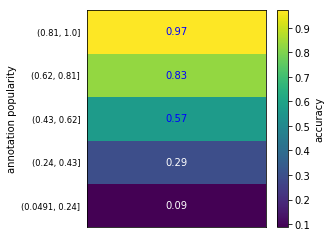

In [51]:
plot_fairness(data_metric, 'accuracy', 'annotation popularity')

In [19]:
### Evaluate the fairness of the model

# The fairness performance are based on the full dataset information (original ToxicityDataset),
# But they are measured separately for the training and test sets (ToxicityDataset folds). (Possibly we can include the last fold which contains NA values)

metrics_inclusiveness = InclusivenessLabelDatasetMetric(dataset_orig_test)

TODO: put bins in order
TODO
PLOT TODO


..\aif360\metrics\inclusiveness_label_dataset_metric.py:77: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = data.as_matrix(columns=[metric])
c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
..\aif360\metrics\inclusiveness_label_dataset_metric.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  matrix_data = data.as_matrix([metric])


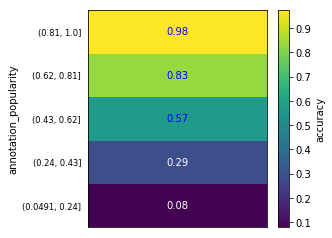

In [20]:
metric_result, data_metric = metrics_inclusiveness.compute_metric(prediction_col, 'label', 'annotation_popularity', ('accuracy',), characterization=True)

TODO: put bins in order
TODO
PLOT TODO
PLOT TODO
PLOT TODO
PLOT TODO
PLOT TODO

..\aif360\metrics\inclusiveness_label_dataset_metric.py:77: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = data.as_matrix(columns=[metric])
c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "



PLOT TODO


..\aif360\metrics\inclusiveness_label_dataset_metric.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  matrix_data = data.as_matrix([metric])


({'accuracy': (0.6676391129320607, 0.5493616314799377),
  'F1': (0.7322584049153598, 0.2908718315151885),
  'TPR': (0.7501303079586417, 0.22831154968403689),
  'TNR': (0.8341603980054093, 0.8553858119227271),
  'FPR': (0.8341603980054092, 0.14461418807727294),
  'FNR': (0.7501303079586417, 0.7716884503159631)},
                 accuracy        F1       TPR       TNR       FPR       FNR
 bin_col                                                                   
 (0.0491, 0.24]  0.078196  0.028912  0.015563  0.545120  0.454880  0.984437
 (0.24, 0.43]    0.289377  0.073433  0.041220  0.824422  0.175578  0.958780
 (0.43, 0.62]    0.570343  0.181206  0.107257  0.939048  0.060952  0.892743
 (0.62, 0.81]    0.833310  0.416584  0.286782  0.976421  0.023579  0.713218
 (0.81, 1.0]     0.975582  0.754224  0.690736  0.991918  0.008082  0.309264)

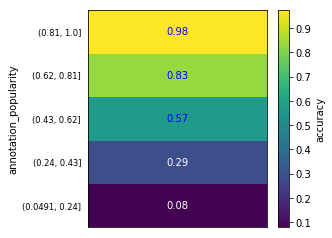

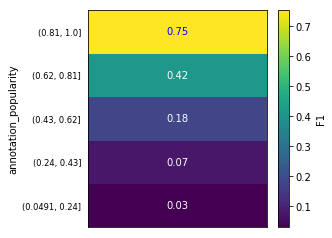

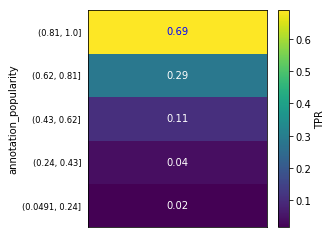

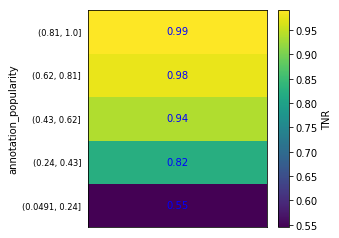

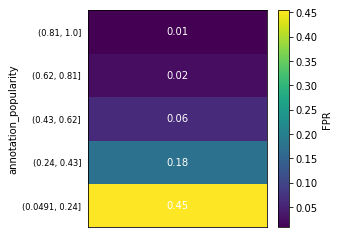

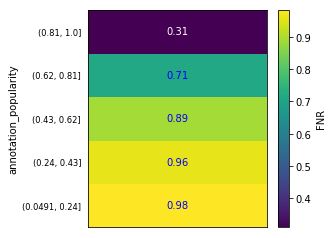

In [21]:
metrics_inclusiveness.compute_metric(prediction_col, 'label', 'annotation_popularity', ('accuracy', 'F1', 'TPR', 'TNR', 'FPR', 'FNR'), characterization=True)

c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


TODO
PLOT TODO
PLOT TODO
PLOT TODO
PLOT TODO
PLOT TODO
PLOT TODO


({'accuracy': (0.9397764035989193, 0.8691609539991728),
  'F1': (0.8757863199734632, 0.3779421463647607),
  'TPR': (0.9040138049732647, 0.2623792418391532),
  'TNR': (0.9897742127715198, 0.9842702256385039),
  'FPR': (0.9897742127715198, 0.015729774361496224),
  'FNR': (0.9040138049732647, 0.7376207581608468)},
                              level_0   index       rev_id  worker_id  label  \
 pop_label                                                                     
 male 18-30 none                19476   23651   13396804.0       1620      0   
 male 18-30 hs                 145064  176273   57159532.0        534      0   
 male 30-45 hs                  40472   49149   22037347.0       2377      0   
 female 30-45 bachelors         33074   40113   19592288.0       1239      0   
 male 18-30 masters            408417  496026  162923883.0       1650      0   
 male 18-30 bachelors          213571  259232   78136416.0       1503      0   
 male 30-45 bachelors          235660  286109  

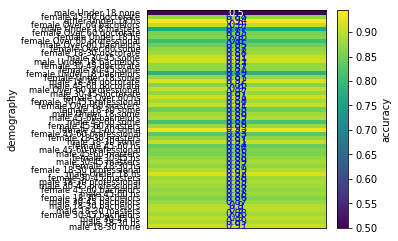

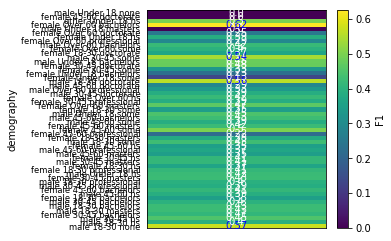

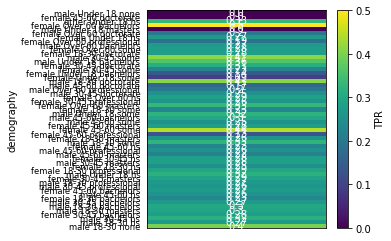

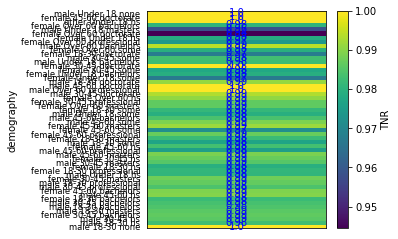

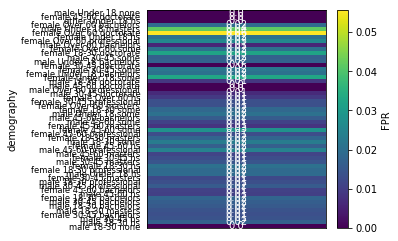

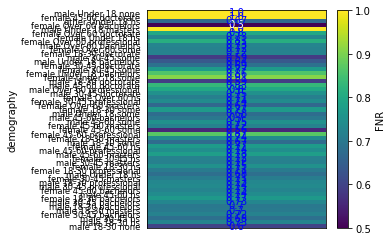

In [22]:
metrics_inclusiveness.compute_metric(prediction_col, 'label', 'demography', ('accuracy', 'F1', 'TPR', 'TNR', 'FPR', 'FNR'), characterization=True)

In [26]:
# metrics_inclusiveness.compute_metric(prediction_col, 'toxicity', 'sample_ambiguity', ('accuracy', 'F1', 'TPR', 'TNR', 'FPR', 'FNR'))

In [23]:
metrics_inclusiveness.compute_metric(prediction_col, 'label', 'annotator_disagreement', ('accuracy', 'F1', 'TPR', 'TNR', 'FPR', 'FNR'))

c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
..\aif360\metrics\inclusiveness_label_dataset_metric.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  matrix_data = data.as_matrix([metric])
c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
..\aif360\metrics\inclusiveness_label_dataset_metric.py:32: RuntimeWarning: Mean of empt

({'accuracy': (0.8069760231117868, 0.638475492124209),
  'F1': (0.9002272082638393, 0.1988737664933112),
  'TPR': (nan, nan),
  'TNR': (nan, nan),
  'FPR': (nan, nan),
  'FNR': (nan, nan)},
                           level_0          index        rev_id    worker_id  \
 bin_col                                                                       
 (-0.000646, 0.129]  203001.098279  246474.684977  7.932742e+07  2031.755460   
 (0.129, 0.258]      211768.973753  257115.758530  8.299286e+07  2301.519685   
 (0.258, 0.388]      185939.285714  225754.964286  7.320640e+07  2694.892857   
 (0.388, 0.517]      169818.266667  206180.333333  6.655530e+07  2185.266667   
 (0.517, 0.646]      107706.777778  130805.222222  4.334087e+07  3453.666667   
 
                        label  label_score  english_first_language  \
 bin_col                                                             
 (-0.000646, 0.129]  0.125083     0.261085                0.181337   
 (0.129, 0.258]      0.202100     0.15